# Assignment 2

In this assignment,we are going to implement the well-known Canny edge detector.

In [1]:
from __future__ import print_function

#Setup

# The Random module might be used for pseudo-random number generators
import random 

# Numpy plays important role in scientific computing with Python, especially for coding vision algorithms. 
# This package will be one of our most used libraries in this class. Make sure you spend enough time for practicing it.
import numpy as np

# This module is used to measure the execution time of code sections  
from time import time

#This module is used to read and write image in various formats
from skimage import io

#Imports all the methods in the file Canny.py
from Canny import *

#Matplotlib is a useful plotting library for python 
import matplotlib.pyplot as plt

# This code is to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 15.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

## Canny Edge Detector
As described in the lecture 6, the Canny edge detection algorithm can be divided into four steps:
1. Smoothing
2. Computing image gradients
3. Non-maximum suppression
4. Hysterisis thresholding

### Step 1: Smoothing (1 point)

We first smooth the input image by convolving it with a Gaussian kernel. The equation for a Gaussian kernel of size $(2k+1)\times(2k+1)$ is given by:

$$h_{ij}=\frac{1}{2\pi\sigma^2}\exp{\Bigl(-\frac{(i-k)^2+(j-k)^2}{2\sigma^2}\Bigr)}, 0\leq i,j < 2k+1$$

Implement **`gaussian_kernel`** in `Canny.py` and run the code below.

In [2]:
# Define 3x3 Gaussian kernel with std = 1
kernel = gaussian_kernel(3, 1)
print(kernel)
kernel_test = np.array(
    [[ 0.05854983, 0.09653235, 0.05854983],
     [ 0.09653235, 0.15915494, 0.09653235],
     [ 0.05854983, 0.09653235, 0.05854983]]
)
# Test Gaussian kernel
if not np.allclose(kernel, kernel_test):
    print('Incorrect values! Please check your implementation.')

[[0.05854983 0.09653235 0.05854983]
 [0.09653235 0.15915494 0.09653235]
 [0.05854983 0.09653235 0.05854983]]


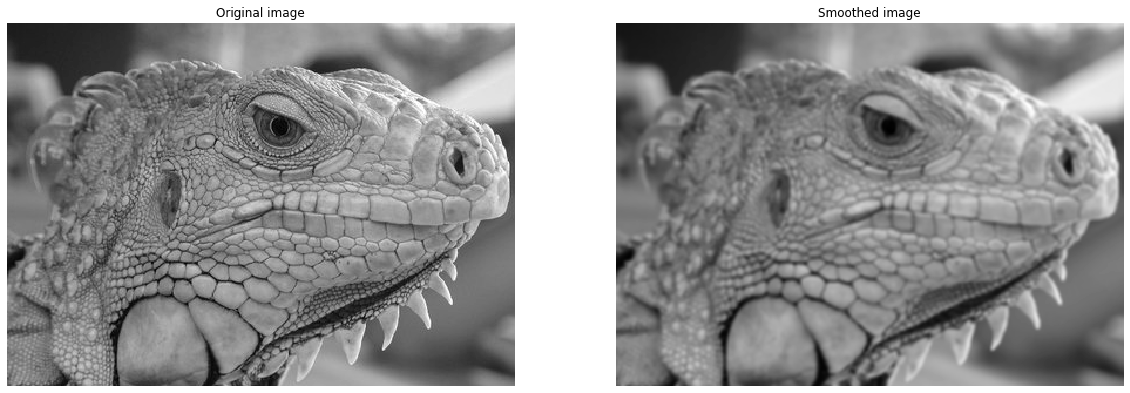

In [3]:
# Test with different kernel_size and sigma
kernel_size = 5
sigma = 1.4

# Load image
img = io.imread('iguana.png', as_gray=True)

# Define 5x5 Gaussian kernel with std = sigma
kernel = gaussian_kernel(kernel_size, sigma)

# Convolve image with kernel to achieve smoothed effect
smoothed = conv(img, kernel)

plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(smoothed)
plt.title('Smoothed image')
plt.axis('off')

plt.show()

### Step 2: Computing image gradients (2 points)
The gradient of a 2D scalar function $I:\mathbb{R}^2\rightarrow{\mathbb{R}}$ in Cartesian coordinate is defined by:

$$\nabla{I(x,y)}=\bigl[\frac{\partial{I}}{\partial{x}},\frac{\partial{I}}{\partial{y}}\bigr],$$

where

$$
\frac{\partial{I(x,y)}}{\partial{x}}=\lim_{\Delta{x}\to{0}}\frac{I(x+\Delta{x},y)-I(x,y)}{\Delta{x}} \\
\frac{\partial{I(x,y)}}{\partial{y}}=\lim_{\Delta{y}\to{0}}\frac{I(x,y+\Delta{y})-I(x,y)}{\Delta{y}}.
$$

In case of images, we can approximate the partial derivatives by taking differences at one pixel intervals:

$$
\frac{\partial{I(x,y)}}{\partial{x}}\approx{\frac{I(x+1,y)-I(x-1,y)}{2}} \\
\frac{\partial{I(x,y)}}{\partial{y}}\approx{\frac{I(x,y+1)-I(x,y-1)}{2}}
$$

Accordingly, the partial derivatives can be computed by convolving the image $I$ with two appropriate kernels: $D_x = \begin{bmatrix} 0.5 & 0 & -0.5 \end{bmatrix}$(row vector) and $D_y = \begin{bmatrix} 0.5 \\ 0 \\ -0.5 \end{bmatrix}$(column vector):

$$
\frac{\partial{I}}{\partial{x}}\approx{I*D_x}=G_x \\
\frac{\partial{I}}{\partial{y}}\approx{I*D_y}=G_y
$$

(**1 point**) Implement **`partial_x`** and **`partial_y`** using `conv` defined in `Canny.py`.

*-Hint: Remember that convolution flips the kernel.*

In [4]:
# Test input
I = np.array(
    [[0, 0, 0],
     [0, 1, 0],
     [0, 0, 0]]
)

# Expected outputs
I_x_test = np.array(
    [[ 0, 0, 0],
     [ 0.5, 0, -0.5],
     [ 0, 0, 0]]
)

I_y_test = np.array(
    [[ 0, 0.5, 0],
     [ 0, 0, 0],
     [ 0, -0.5, 0]]
)

# Compute partial derivatives
I_x = partial_x(I)
I_y = partial_y(I)

# Test correctness of partial_x and partial_y
if not np.all(I_x == I_x_test):
    print('partial_x incorrect')
    
if not np.all(I_y == I_y_test):
    print('partial_y incorrect')

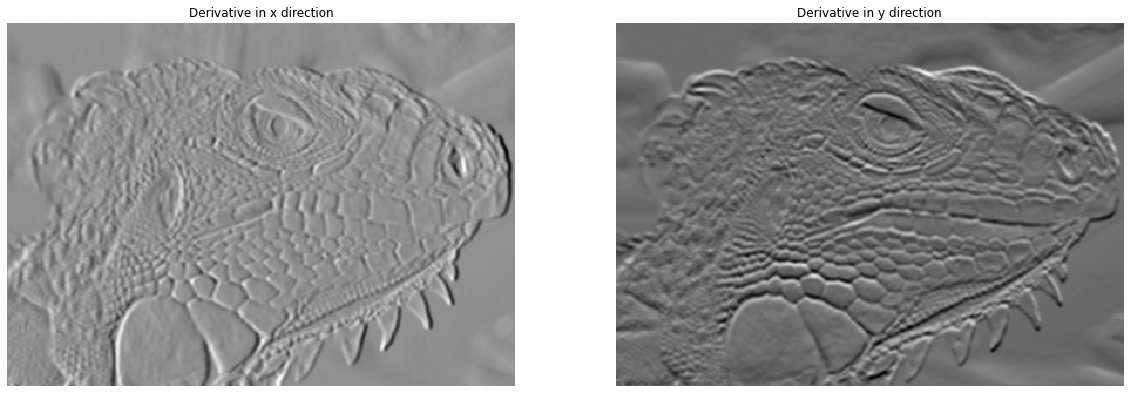

In [5]:
# Compute partial derivatives of smoothed image
Gx = partial_x(smoothed)
Gy = partial_y(smoothed)

plt.subplot(1,2,1)
plt.imshow(Gx)
plt.title('Derivative in x direction')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(Gy)
plt.title('Derivative in y direction')
plt.axis('off')

plt.show()

Now, we can compute the magnitude and direction of gradient with the two partial derivatives:

$$
G = \sqrt{G_{x}^{2}+G_{y}^{2}} \\
\Theta = arctan\bigl(\frac{G_{y}}{G_{x}}\bigr)
$$

(**1 point**) Implement **`gradient`** in `Canny.py` which takes in an image and outputs $G$ and $\Theta$.

*-Hint: Use np.arctan2 to compute $\Theta$.*

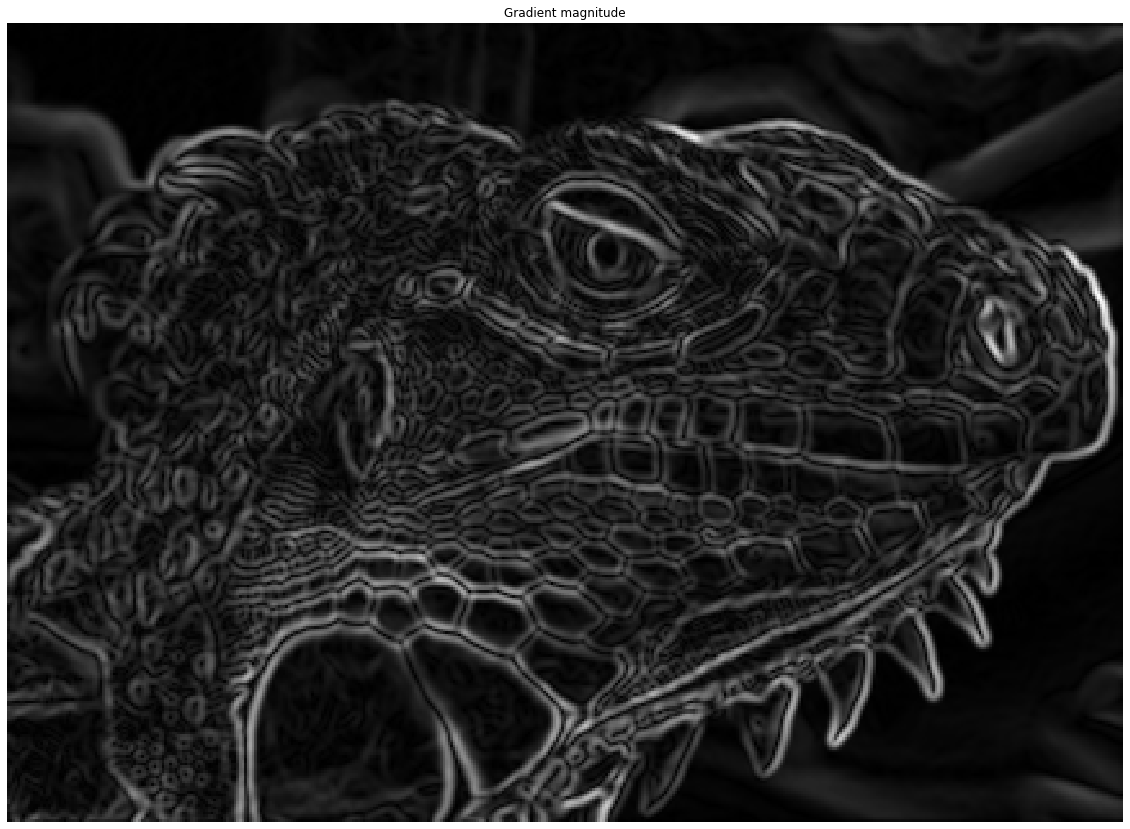

In [6]:
G, theta = gradient(smoothed)

if not np.all(G >= 0):
    print('Magnitude of gradients should be non-negative.')
    
if not np.all((theta >= 0) * (theta < 360)):
    print('Direction of gradients should be in range 0 <= theta < 360')

plt.imshow(G)
plt.title('Gradient magnitude')
plt.axis('off')
plt.show()

### Step 3: Non-maximum suppression (2 points)
As explained in the lecture, the edges extracted from the gradient of the smoothed image are quite thick and blurry. The purpose of this step is to convert the "blurred" edges into "sharp" edges. Basically, this is done by preserving all local maxima in the gradient image and discarding everything else. The algorithm is for each pixel (x,y) in the gradient image:
1. Round the gradient direction $\Theta[y,x]$ to the nearest 45 degrees, corresponding to the use of an 8-connected neighborhood.

2. Compare the edge strength of the current pixel with the edge strength of the pixel in the positive and negative gradient directions. For example, if the gradient direction is south (theta=90), compare with the pixels to the north and south. Note that, if the current pixel is at the image boundary, we just set it to zeros because one of its two neighbors might be outside the image.

3. If the edge strength of the current pixel is the largest (i.e., G(pixel) $\geqslant$ G(positive neighbor) and G(pixel) $\geqslant$ G(negative neighbor), where G is the gradient magnitude of image); preserve the value of the edge strength. If not, suppress (i.e. remove) the value.

Implement **`non_maximum_suppression`** in `Canny.py`

I provide the correct output and the difference between it and your result for debugging purposes. If you see white spots in the Difference image, you should check your implementation.

In [7]:
# Test synthetic input
g = np.array(
    [[0.4, 0.5, 0.6],
     [0.3, 0.5, 0.7],
     [0.4, 0.5, 0.6]]
)
# Print out non-maximum suppressed output
# varying theta
for angle in range(0, 180, 45):
    print('Thetas:', angle)
    t = np.ones((3, 3)) * angle # Initialize theta
    print(non_maximum_suppression(g, t))

Thetas: 0
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Thetas: 45
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Thetas: 90
[[0.  0.  0. ]
 [0.  0.5 0. ]
 [0.  0.  0. ]]
Thetas: 135
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


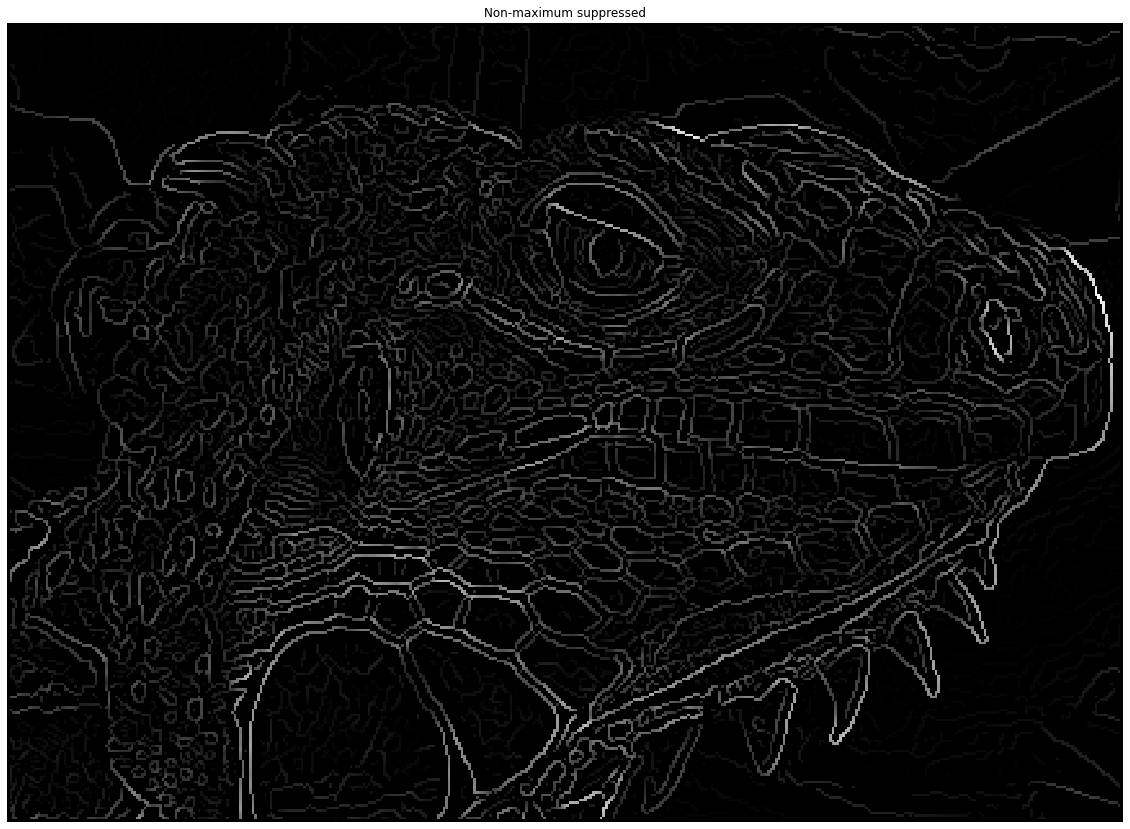

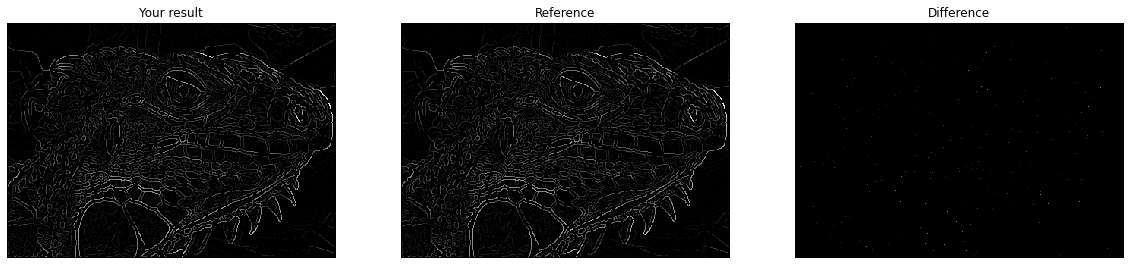

In [8]:
nms = non_maximum_suppression(G, theta)
plt.imshow(nms)
plt.title('Non-maximum suppressed')
plt.axis('off')
plt.show()

plt.subplot(1, 3, 1)
plt.imshow(nms)
plt.axis('off')
plt.title('Your result')

plt.subplot(1, 3, 2)
reference = np.load('references/iguana_non_max_suppressed.npy')
plt.imshow(reference)
plt.axis('off')
plt.title('Reference')

plt.subplot(1, 3, 3)
plt.imshow(abs(nms - reference))
plt.title('Difference')
plt.axis('off')
plt.show()

### Step 4: Hysterisis thresholding (Extra credit: 1 point)

The edge-pixels remaining after the non-maximum suppression step are (still) marked with their strength pixel-by-pixel. Many of these will probably be true edges in the image, but some may be caused by noise or color variations, for instance, due to rough surfaces. The simplest way to discern between these would be to use a threshold, so that only edges stronger than a certain value would be preserved. The Canny edge detection algorithm uses double thresholding. Edge pixels stronger than the high threshold are marked as strong; edge pixels weaker than the low threshold are suppressed and edge pixels between the two thresholds are marked as weak.

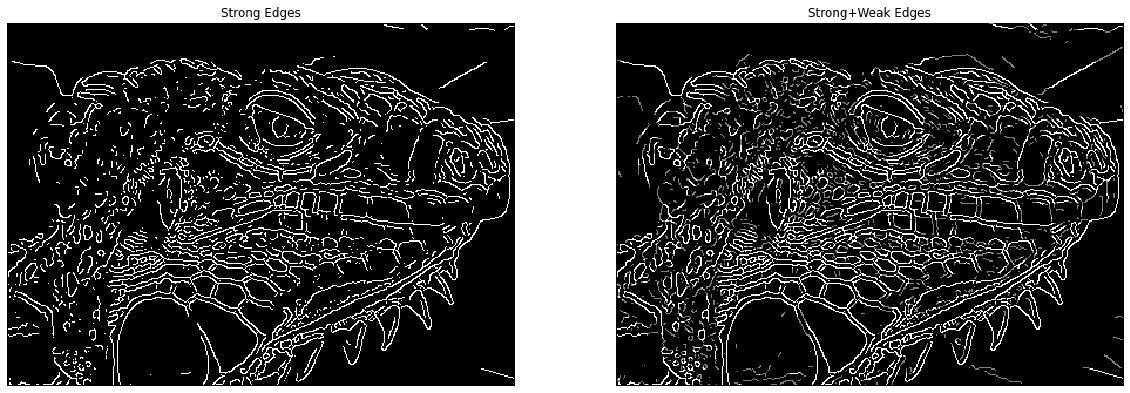

In [9]:
low_threshold = 0.02
high_threshold = 0.03

# function double_thresholding() has been implemented in Canny.py file
strong_edges, weak_edges = double_thresholding(nms, high_threshold, low_threshold)
assert(np.sum(strong_edges & weak_edges) == 0)

edges=strong_edges * 1.0 + weak_edges * 0.5

plt.subplot(1,2,1)
plt.imshow(strong_edges)
plt.title('Strong Edges')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(edges)
plt.title('Strong+Weak Edges')
plt.axis('off')

plt.show()

#### Linking edges 

Strong edges are interpreted as “certain edges”, and can immediately be included in the final edge image. Weak edges are included if and only if they are connected to strong edges. The logic is of course that noise and other small variations are unlikely to result in a strong edge (with proper adjustment of the threshold levels). Thus strong edges will (almost) only be due to true edges in the original image. The weak edges can either be due to true edges or noise/color variations. The latter type will probably be distributed independently of edges on the entire image, and thus only a small amount will be located adjacent to strong edges. Weak edges due to true edges are much more likely to be connected directly to strong edges.

Implement **`link_edges`** in `Canny.py`. This task is relatively challenging because you might need to run breadth-first search algorithm to mark the potential edges as true edges. Hence, if the you can implement **`link_edges`** successfully, you will get extra point.

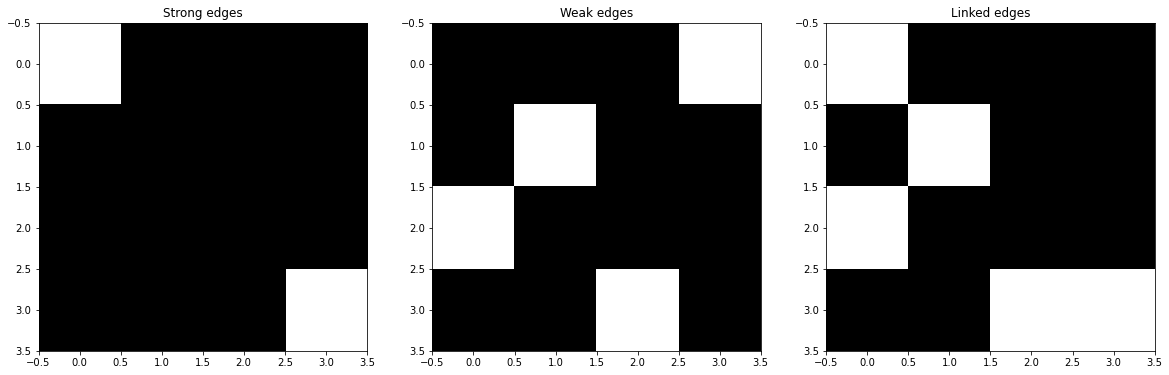

In [10]:
test_strong = np.array(
    [[1, 0, 0, 0],
     [0, 0, 0, 0],
     [0, 0, 0, 0],
     [0, 0, 0, 1]]
)

test_weak = np.array(
    [[0, 0, 0, 1],
     [0, 1, 0, 0],
     [1, 0, 0, 0],
     [0, 0, 1, 0]]
)

test_linked = link_edges(test_strong, test_weak)

plt.subplot(1, 3, 1)
plt.imshow(test_strong)
plt.title('Strong edges')

plt.subplot(1, 3, 2)
plt.imshow(test_weak)
plt.title('Weak edges')

plt.subplot(1, 3, 3)
plt.imshow(test_linked)
plt.title('Linked edges')
plt.show()

Now, let's test on the real strong_edges and weak_edges to get the final output. I provide the correct output and the difference between it and your result for debugging purposes.

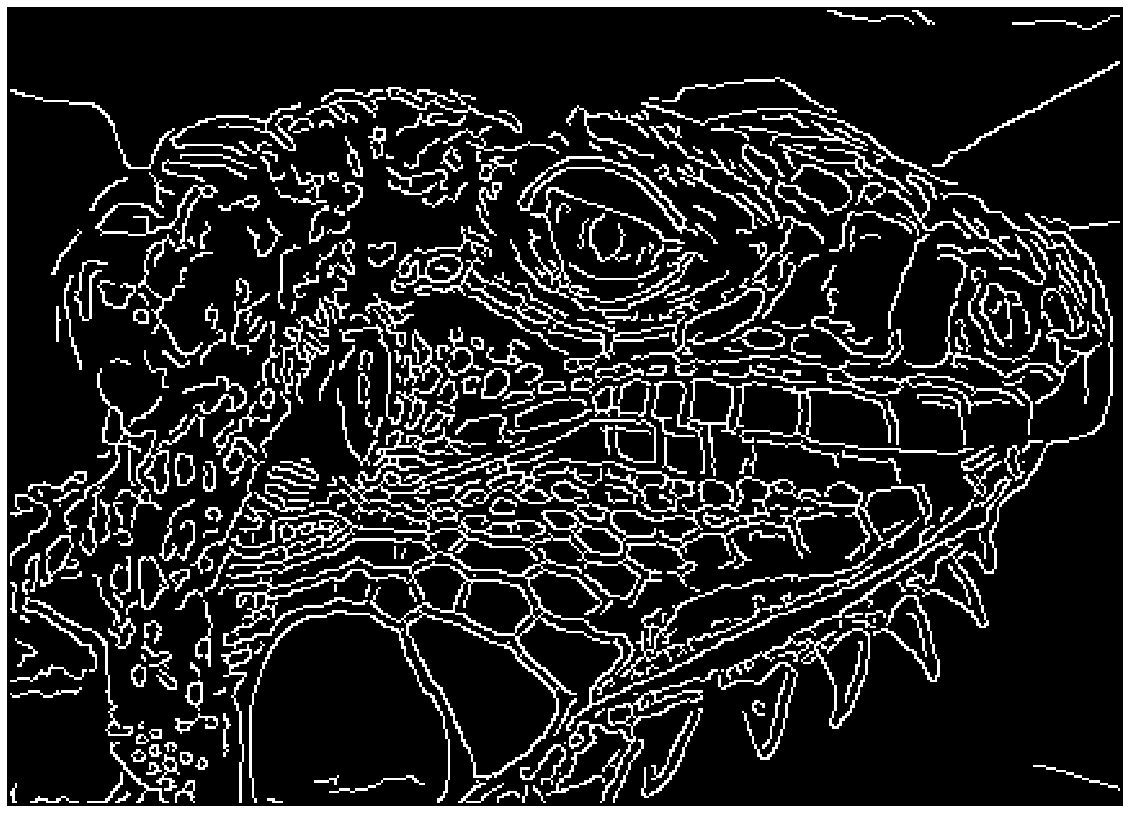

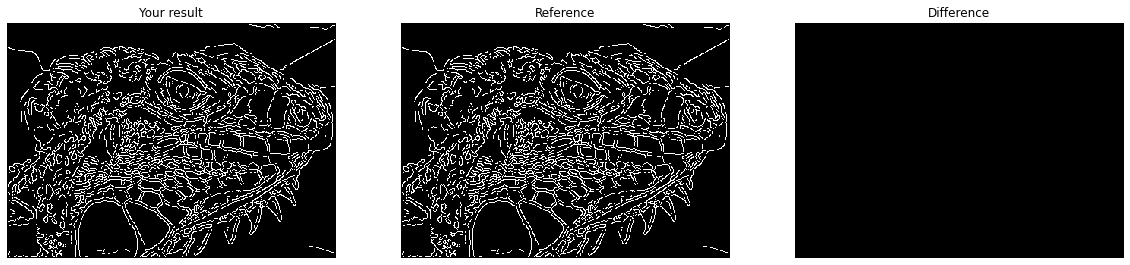

In [11]:
edges = link_edges(strong_edges, weak_edges)

plt.imshow(edges)
plt.axis('off')
plt.show()

plt.subplot(1, 3, 1)
plt.imshow(edges)
plt.axis('off')
plt.title('Your result')

plt.subplot(1, 3, 2)
reference = np.load('references/iguana_edge_tracking_ref.npy')
plt.imshow(reference)
plt.axis('off')
plt.title('Reference')

plt.subplot(1, 3, 3)
plt.imshow(edges ^ reference)
plt.title('Difference')
plt.axis('off')
plt.show()